In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seunghwanlee01","key":"0e411810c80af5d8f4901c512b3369c2"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#dataset down!
!kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:18<00:00, 18.4MB/s]
100% 331M/331M [00:18<00:00, 18.3MB/s]


In [ ]:
!unzip /content/utkface-new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jp

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import backend as k
from glob import glob
import seaborn as sns

In [ ]:
folder_name = 'UTKFace'

In [ ]:
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()

    return df

In [ ]:
df = parse_dataset(folder_name)

In [ ]:
df.head()

age  gender    race                                           file
0  36.0    male   white  UTKFace/36_0_0_20170117135436708.jpg.chip.jpg
1  29.0    male   black  UTKFace/29_0_1_20170117204407433.jpg.chip.jpg
2  25.0  female  indian  UTKFace/25_1_3_20170119172053938.jpg.chip.jpg
3  52.0    male   black  UTKFace/52_0_1_20170113174958212.jpg.chip.jpg
4   3.0  female   white   UTKFace/3_1_0_20170109190700159.jpg.chip.jpg

In [ ]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)

    fig.show()

In [ ]:
plot_distribution(df['race'])

In [ ]:
plot_distribution(df['gender'])

In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

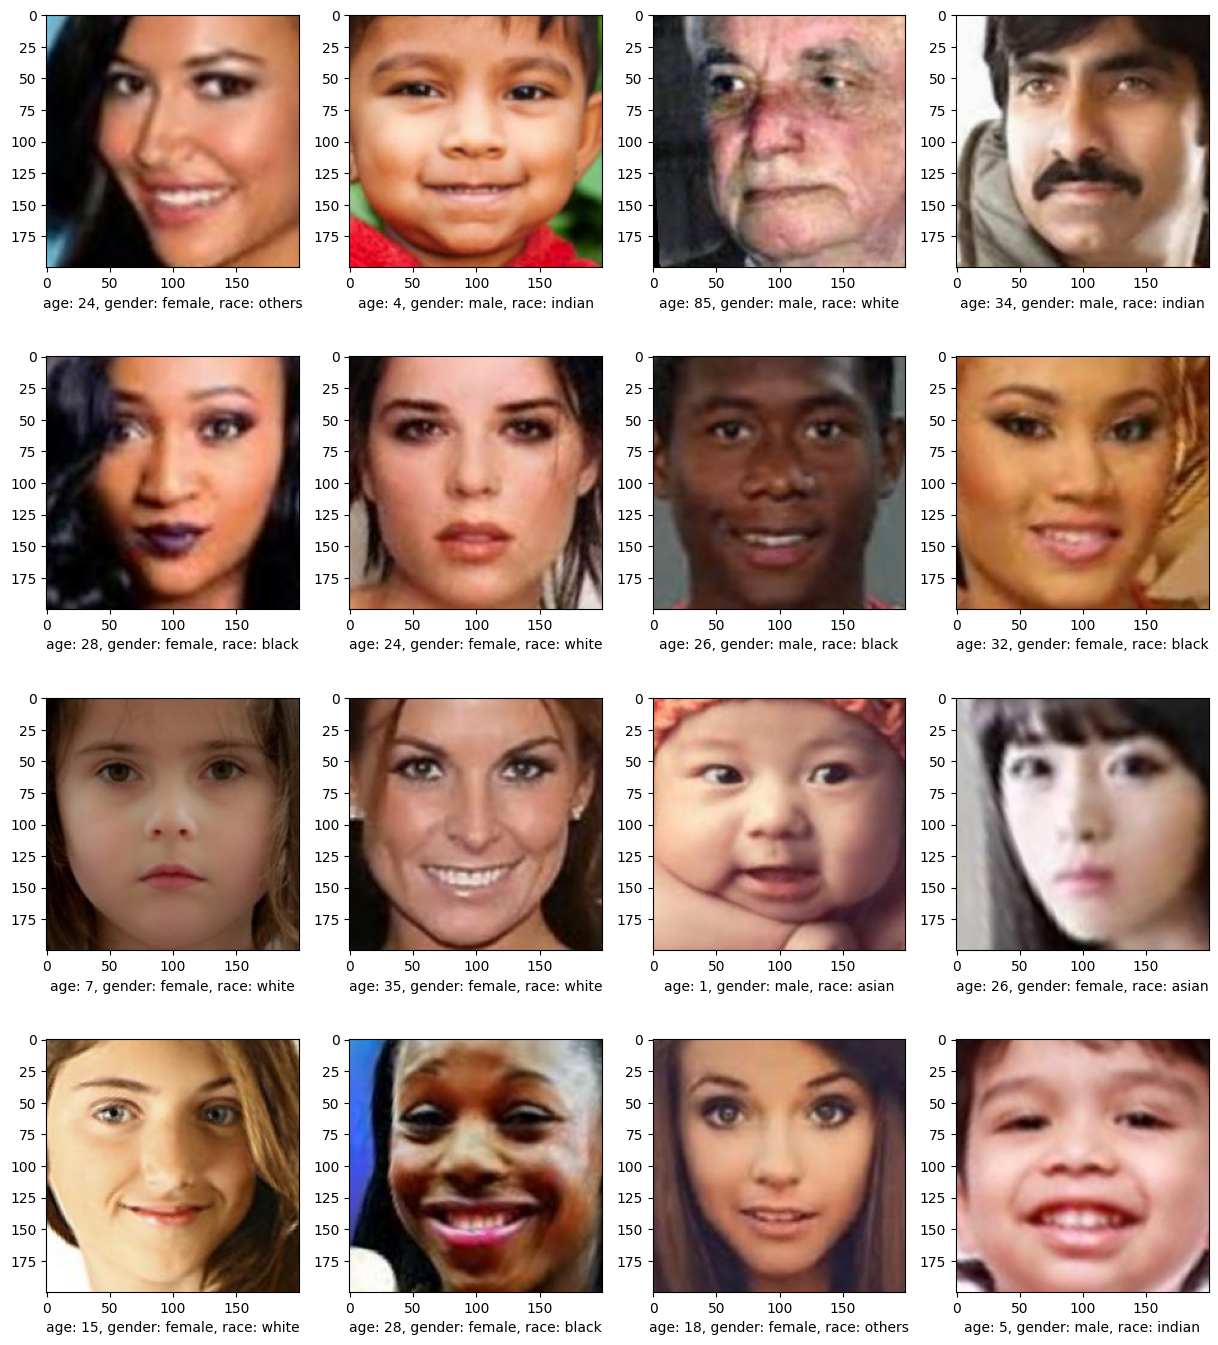

In [ ]:
import math
n=16
random_indices = np.random.choice(df.index.tolist(), size=n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   img = cv2.imread(df['file'][x])
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   ax.imshow(img)
   pic_age = df['age'][x]
   pic_gender = df['gender'][x]
   pic_race = df['race'][x]
   ax.set_xlabel('age: {}, gender: {}, race: {}'.format(int(pic_age),pic_gender, pic_race))


In [ ]:
images = []
age = []
gender = []
for img in os.listdir(folder_name):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  img = cv2.imread(str(folder_name)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = img
  images.append(np.array(img))
  age.append(np.array(ages))
  gender.append(np.array(genders))

age = np.array(age,dtype=np.int64)
images = np.array(images)
gender = np.array(gender,np.uint64)


In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42, test_size=0.4)
x_valid_age , x_test_age  , y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, random_state=42, test_size=0.5)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42, test_size = 0.4)
x_valid_gender , x_test_gender  , y_valid_gender, y_test_gender = train_test_split(x_test_gender, y_test_gender, random_state=42, test_size=0.5)


In [ ]:
from tensorflow.keras.optimizers import Adam
init_lr = 1e-4
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,
    decay_rate=0.96,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)

In [ ]:
age_model = Sequential([
    Conv2D(128, kernel_size =3, input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'linear', name = 'age')
])
age_model.compile(loss="mse", optimizer=opt, metrics = ['mae'])

In [ ]:
gender_model = Sequential([
    Conv2D(36, kernel_size=3,input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'sigmoid', name = 'gender')
])

gender_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5),
             ModelCheckpoint(filepath='./best_model_{val_loss:.2f}.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [ ]:
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_valid_age, y_valid_age), batch_size = 32, epochs=50, callbacks = callbacks)

Epoch 1/50
445/445 [==============================] - ETA: 0s - loss: 194.1877 - mae: 10.3692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



445/445 [==============================] - 102s 205ms/step - loss: 194.1877 - mae: 10.3692 - val_loss: 136.5692 - val_mae: 9.0769
Epoch 2/50
445/445 [==============================] - 87s 195ms/step - loss: 115.4819 - mae: 8.0448 - val_loss: 152.3736 - val_mae: 8.9481
Epoch 3/50
445/445 [==============================] - 88s 197ms/step - loss: 92.7081 - mae: 7.1174 - val_loss: 109.9420 - val_mae: 7.3892
Epoch 4/50
445/445 [==============================] - 88s 198ms/step - loss: 78.5320 - mae: 6.5633 - val_loss: 84.0422 - val_mae: 6.7794
Epoch 5/50
445/445 [==============================] - 88s 197ms/step - loss: 68.3100 - mae: 6.1272 - val_loss: 87.0326 - val_mae: 6.9538
Epoch 6/50
445/445 [==============================] - 88s 198ms/step - loss: 62.2497 - mae: 5.8406 - val_loss: 79.8057 - val_mae: 6.5684
Epoch 7/50
445/445 [==============================] - 88s 197ms/step - loss: 57.7982 - mae: 5.6021 - val_loss: 82.0134 - val_mae: 6.4430
Epoch 8/50
445/445 [=========================

In [ ]:
age_model.save('age_model.keras')

In [ ]:
history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_valid_gender, y_valid_gender), batch_size=32, callbacks = callbacks, epochs=50)

Epoch 1/50
445/445 [==============================] - 41s 78ms/step - loss: 0.4802 - accuracy: 0.7805 - val_loss: 0.3992 - val_accuracy: 0.8123
Epoch 2/50
  1/445 [..............................] - ETA: 26s - loss: 0.2825 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



445/445 [==============================] - 32s 71ms/step - loss: 0.3325 - accuracy: 0.8564 - val_loss: 0.3281 - val_accuracy: 0.8549
Epoch 3/50
445/445 [==============================] - 32s 71ms/step - loss: 0.2727 - accuracy: 0.8851 - val_loss: 0.3075 - val_accuracy: 0.8682
Epoch 4/50
445/445 [==============================] - 32s 72ms/step - loss: 0.2263 - accuracy: 0.9097 - val_loss: 0.2757 - val_accuracy: 0.8817
Epoch 5/50
445/445 [==============================] - 32s 71ms/step - loss: 0.1941 - accuracy: 0.9246 - val_loss: 0.2827 - val_accuracy: 0.8792
Epoch 6/50
445/445 [==============================] - 32s 71ms/step - loss: 0.1691 - accuracy: 0.9357 - val_loss: 0.2651 - val_accuracy: 0.8891
Epoch 7/50
445/445 [==============================] - 32s 71ms/step - loss: 0.1530 - accuracy: 0.9457 - val_loss: 0.2607 - val_accuracy: 0.8891
Epoch 8/50
445/445 [==============================] - 32s 71ms/step - loss: 0.1386 - accuracy: 0.9504 - val_loss: 0.2625 - val_accuracy: 0.8889
Epo

In [ ]:
gender_model.save('gender_model.keras')

In [ ]:
from google.colab import files

files.download('gender_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history_age

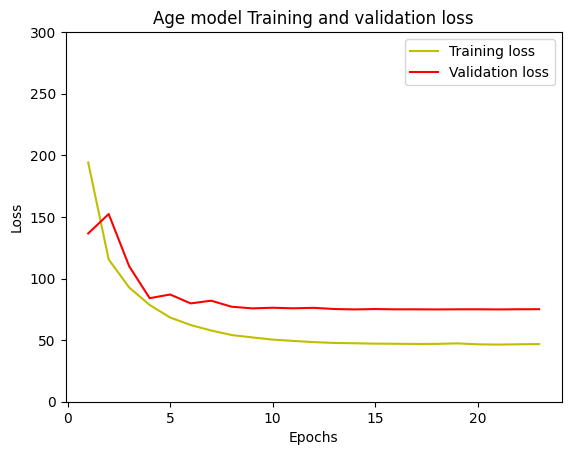

In [ ]:
history = history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Age model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,300)
plt.legend()
plt.show()

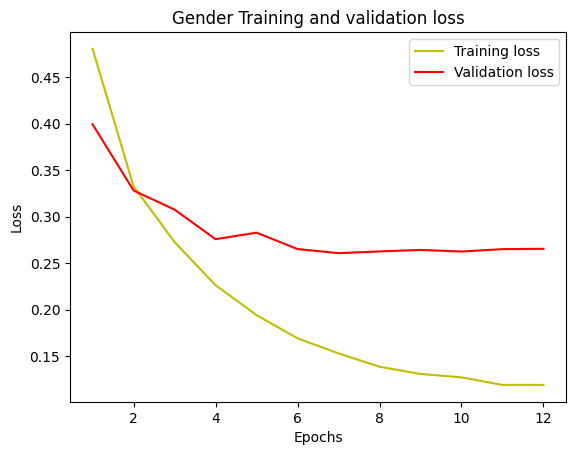

In [ ]:
history = history_gender
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Gender Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
len(x_test_age)

5927

In [ ]:
y_test_age[0]

28

In [ ]:
age_preds = age_model.predict(x_test_age)

149/149 [==============================] - 8s 53ms/step


In [ ]:
gender_preds = gender_model.predict(x_test_gender)

149/149 [==============================] - 3s 18ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
age_mae = mean_absolute_error(y_test_age, age_preds)

age_mae

6.302725511490521

In [ ]:
gender_accuracy = accuracy_score(y_test_gender, np.round(gender_preds))

gender_accuracy

0.8916069169126951

(array([1927.,  208.,  158.,  117.,  108.,   99.,  138.,  138.,  190.,
        1659.]),
 array([6.56521393e-10, 9.99999866e-02, 1.99999973e-01, 2.99999952e-01,
        3.99999946e-01, 4.99999940e-01, 5.99999905e-01, 6.99999928e-01,
        7.99999893e-01, 8.99999917e-01, 9.99999881e-01]),
 <BarContainer object of 10 artists>)

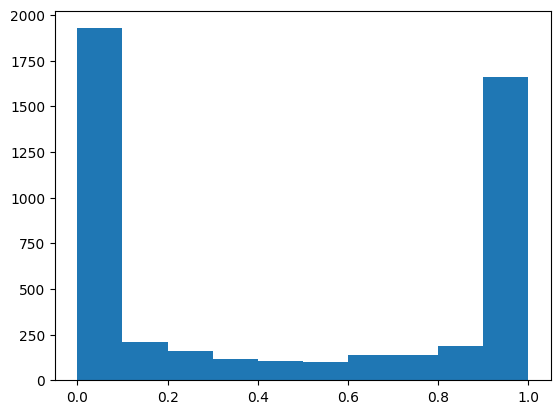

In [ ]:
plt.hist(gender_preds.ravel())

In [ ]:
print(classification_report(y_test_gender,np.round(gender_preds)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2518
           1       0.88      0.88      0.88      2224

    accuracy                           0.89      4742
   macro avg       0.89      0.89      0.89      4742
weighted avg       0.89      0.89      0.89      4742



In [ ]:
confusion_matrix(y_test_gender,np.round(gender_preds))

array([[2261,  257],
       [ 257, 1967]])

<ipython-input-48-c2f7ea717dbc>:21: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



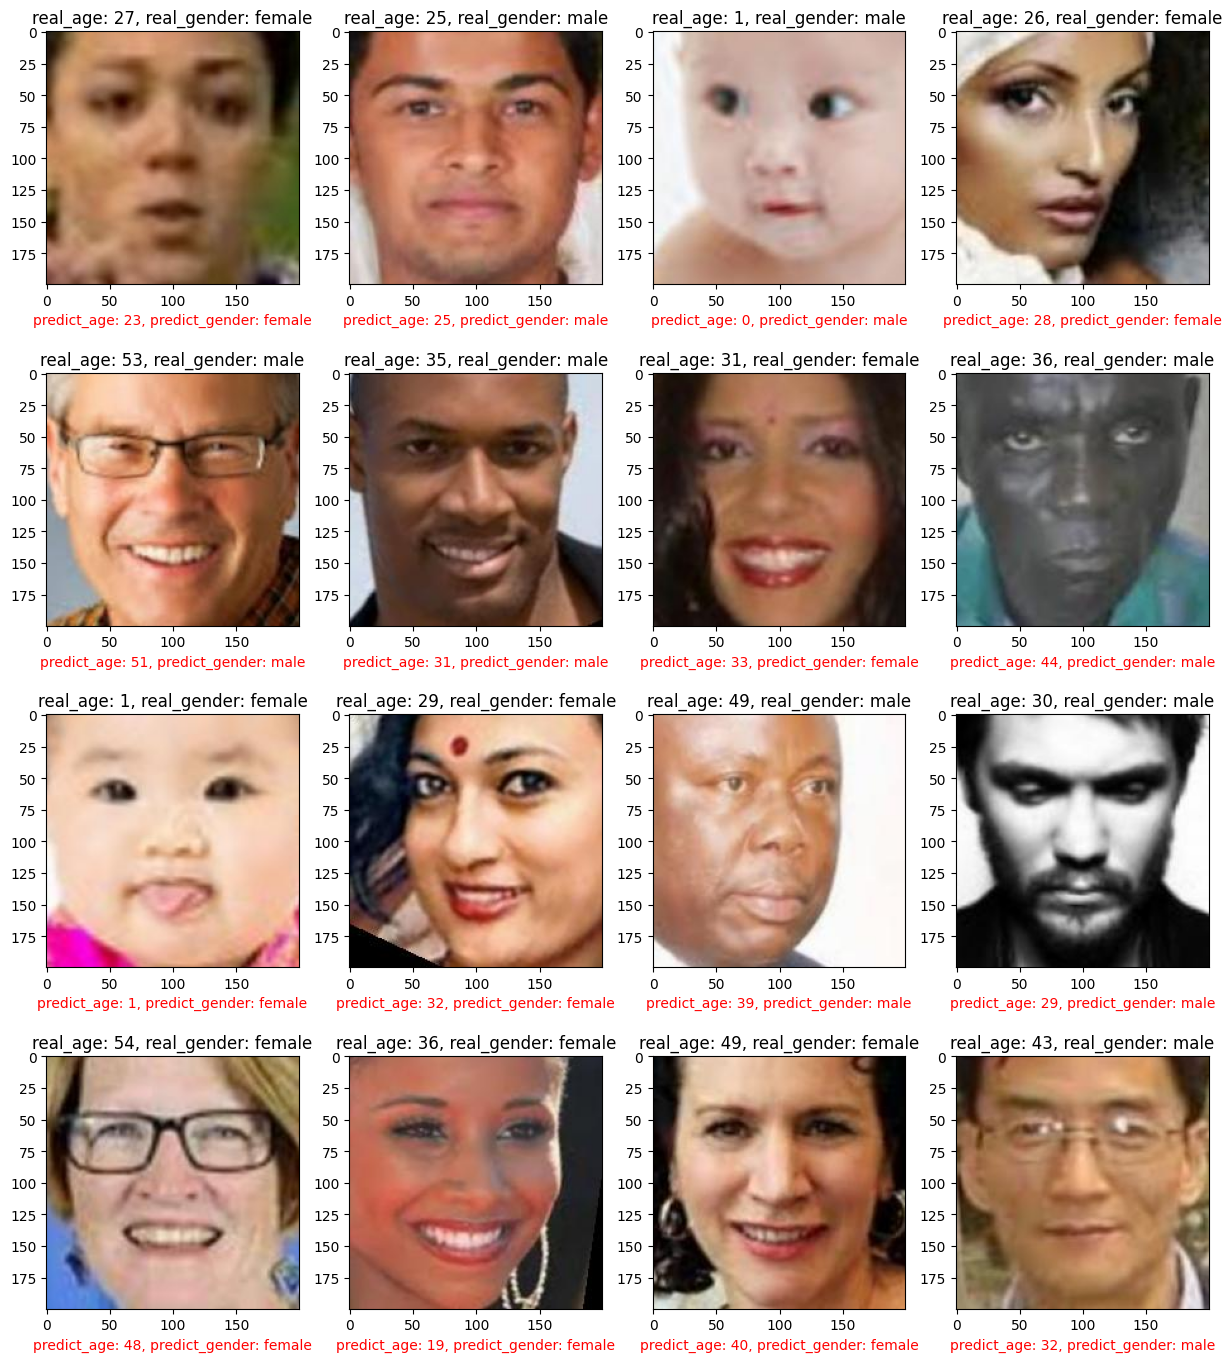

In [ ]:
import math
n=16
random_indices = np.random.choice(len(x_test_age), size=n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   ax.imshow(x_test_age[x])
   real_age = y_test_age[x]
   predict_age = age_preds[x]
   if y_test_gender[x] == 1:
     real_gender = 'female'
   else:
     real_gender = 'male'
   if np.round(gender_preds[x]) == 1:
     predict_gender = 'female'
   else:
     predict_gender ='male'
   ax.set_title('real_age: {}, real_gender: {}'.format(int(real_age),real_gender))
   ax.set_xlabel('predict_age: {}, predict_gender: {}'.format(int(predict_age),predict_gender))
   ax.xaxis.label.set_color('red')


1/1 [==============================] - 0s 17ms/step


<ipython-input-69-31a87b9bc6f5>:40: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 [==============================] - 0s 18ms/step
[array([[39.981075]], dtype=float32), array([[27.456966]], dtype=float32), array([[26.746788]], dtype=float32), array([[37.36314]], dtype=float32), array([[21.37827]], dtype=float32), array([[39.290325]], dtype=float32)] [[0.12271753]]


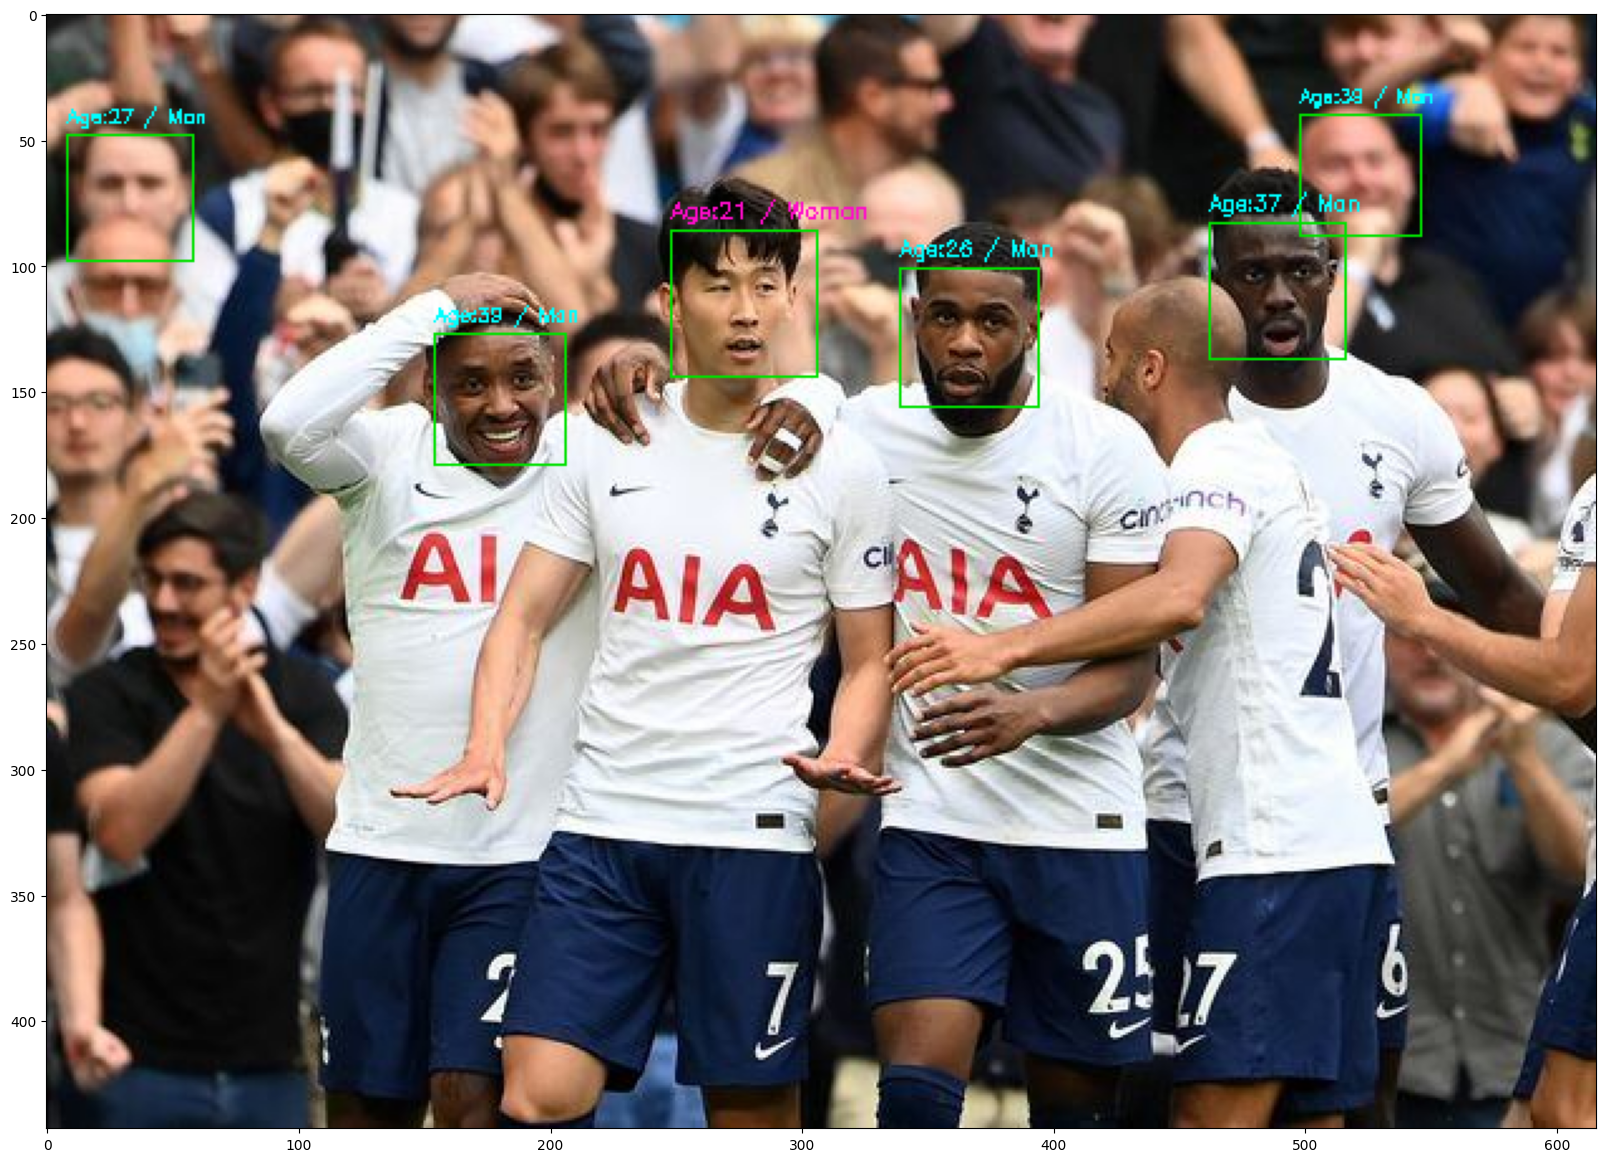

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#model load
age_model_path = "/content/age_model.keras"
gender_model_path = '/content/gender_model.keras'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

#얼굴 검출을 위한 OPENCV Cascadeclassifier load
face_cascade = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

age_ = []
gender_ = []

image_size = 200

pic = cv2.imread('/content/soccer.jpg')
faces = face_cascade.detectMultiScale(pic,scaleFactor=1.15, minNeighbors=8)
age_ = []
gender_ = []
for (x,y,w,h) in faces:
    img = pic[y:y + h, x:x + w]
    img = cv2.resize(img,(image_size,image_size))
    age_predict = age_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    gender_predict = gender_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    age_.append(age_predict)
    gender_.append(np.round(gender_predict))
    gend = np.round(gender_predict)
    if gend == 0:
        gend = 'Man'
        col = (255,255,0)
    else:
        gend = 'Woman'
        col = (203,12,255)
    cv2.rectangle(pic,(x,y),(x+w,y+h),(0,225,0),1)
    cv2.putText(pic,"Age:"+str(int(age_predict))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)
pic1 = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,16))
print(age_,gender_predict)
plt.imshow(pic1)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 195ms/step
[array([[11.669479]], dtype=float32)] [[0.22278225]]


<ipython-input-3-de7f737a3442>:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(pic,"Age:"+str(int(age_predict))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)


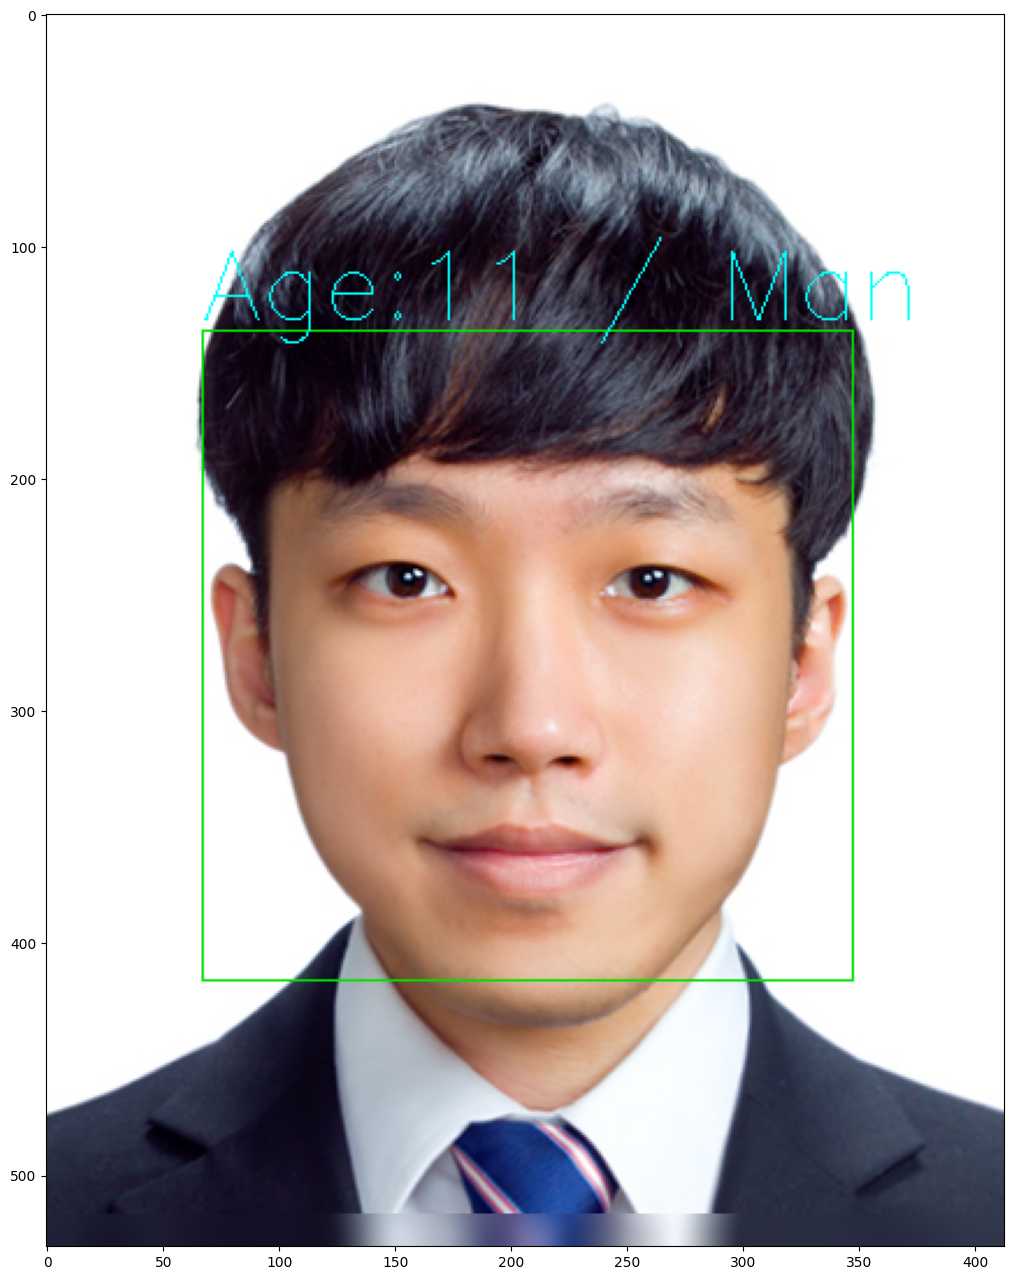

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#model load
age_model_path = "/content/drive/MyDrive/models/age_model.keras"
gender_model_path = '/content/drive/MyDrive/models/gender_model.keras'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

#얼굴 검출을 위한 OPENCV Cascadeclassifier load
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/models/haarcascade_frontalface_default.xml")

age_ = []
gender_ = []

image_size = 200

pic = cv2.imread('/content/0001_1992_29_00000074_D.png')
faces = face_cascade.detectMultiScale(pic,scaleFactor=1.15, minNeighbors=8)
age_ = []
gender_ = []
for (x,y,w,h) in faces:
    img = pic[y:y + h, x:x + w]
    img = cv2.resize(img,(image_size,image_size))
    age_predict = age_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    gender_predict = gender_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    age_.append(age_predict)
    gender_.append(np.round(gender_predict))
    gend = np.round(gender_predict)
    if gend == 0:
        gend = 'Man'
        col = (255,255,0)
    else:
        gend = 'Woman'
        col = (203,12,255)
    cv2.rectangle(pic,(x,y),(x+w,y+h),(0,225,0),1)
    cv2.putText(pic,"Age:"+str(int(age_predict))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)
pic1 = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,16))
print(age_,gender_predict)
plt.imshow(pic1)
plt.show()